## KMeans con un dataset de vinos

Primero cargamos el dataset. El dataset se encuentra en los repositorios de UCI machine learning. Para ello aprovechamos y lo cargamos desde una URL con los métodos de Pandas (ya que Spark no lo permite) y lo mostramos

In [6]:
import pandas as pd
wineDF = spark.createDataFrame(pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", header=0, delimiter=";"))
wineDF.show()

+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|              0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|              0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|              0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0

Comprobamos que todas las columnas que nos interesan para el agrupamiento son del tipo Double (menos la que indica la calidad del vino, que no la vamos a utilizar para el algoritmo ya que nos indica el resultado).

In [12]:
types = [element.dataType for element in wineDF.schema.fields]
print(types)
names = []
for element in wineDF.schema.fields:
    if element.name != "quality":
        names.append(element.name)
print(names)
wineDF = wineDF.na.drop()

[DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, LongType]
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [14]:
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=names, outputCol="features")
wineDF_kmeans = vecAssembler.transform(wineDF).select('quality', 'features')
wineDF_kmeans.show()

+-------+--------------------+
|quality|            features|
+-------+--------------------+
|      5|[7.4,0.7,0.0,1.9,...|
|      5|[7.8,0.88,0.0,2.6...|
|      5|[7.8,0.76,0.04,2....|
|      6|[11.2,0.28,0.56,1...|
|      5|[7.4,0.7,0.0,1.9,...|
|      5|[7.4,0.66,0.0,1.8...|
|      5|[7.9,0.6,0.06,1.6...|
|      7|[7.3,0.65,0.0,1.2...|
|      7|[7.8,0.58,0.02,2....|
|      5|[7.5,0.5,0.36,6.1...|
|      5|[6.7,0.58,0.08,1....|
|      5|[7.5,0.5,0.36,6.1...|
|      5|[5.6,0.615,0.0,1....|
|      5|[7.8,0.61,0.29,1....|
|      5|[8.9,0.62,0.18,3....|
|      5|[8.9,0.62,0.19,3....|
|      7|[8.5,0.28,0.56,1....|
|      5|[8.1,0.56,0.28,1....|
|      4|[7.4,0.59,0.08,4....|
|      6|[7.9,0.32,0.51,1....|
+-------+--------------------+
only showing top 20 rows



Es importante saber antes de usar Kmeans, cuantas agrupaciones queremos realizar. Es por ello que intentamos, como se muestra en el ejemplo, sacar un valor de K para el cual ya no se "maximize" la ganancia

In [16]:
import numpy as np
from pyspark.ml.clustering import KMeans
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(wineDF_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(wineDF_kmeans)

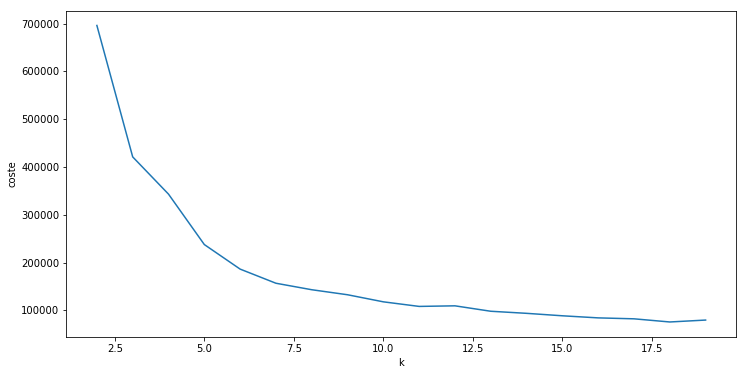

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize =(12,6))
ax.plot(range(2,20),cost[2:20])
_ = ax.set_xlabel('k')
_ = ax.set_ylabel('coste')

En principio vamos a intentar quedarnos con un K de 11, a partir del cual la ganacia es realmente pequeña, y sabiendo además que la calidad del vino se va a medir de 0 a 10

In [26]:
kmeans_k = 11
kmeans = KMeans().setK(kmeans_k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(wineDF_kmeans)

In [39]:
predictions = model.transform(wineDF_kmeans).select('quality', 'prediction')
rows = predictions.collect()
print(rows[:3])

[Row(quality=5, prediction=6), Row(quality=5, prediction=0), Row(quality=5, prediction=7)]


In [34]:
wineDF_pred = spark.createDataFrame(rows)
wineDF_pred.show()

+-------+----------+
|quality|prediction|
+-------+----------+
|      5|         6|
|      5|         0|
|      5|         7|
|      6|         7|
|      5|         6|
|      5|         4|
|      5|         7|
|      7|         6|
|      7|         1|
|      5|         8|
|      5|         7|
|      5|         8|
|      5|         7|
|      5|         6|
|      5|         9|
|      5|         9|
|      7|        10|
|      5|         7|
|      4|         6|
|      6|         7|
+-------+----------+
only showing top 20 rows



Ahora salvamos el modelo

In [29]:
model.save("wine_kmeans_model")

Según la documentación y los ejemplos de Spark (https://github.com/apache/spark/blob/v2.2.1/examples/src/main/python/ml/kmeans_example.py), podemos evaluar el modelo, y así lo hacemos

In [37]:
# Evaluamos el clustering computando el "Within Set Sum of Squared Errors" (me permito copiarlo de)
wssse = model.computeCost(wineDF_kmeans)
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 99494.80305208372
